In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import os, os.path as path

from spectrum import FitsSpectrum
from common import list_files, list_directories, tqdm

In [4]:
dib_centers_all = np.array([float(path.basename(dib_file).replace('.ascii', '')) for dib_file in list_files('data/dibs')])
dib_centers_subset = [5780,5797,6196,6379,6613,7224]

def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

def fit_gaussian_for_subspectrum(
    subspectrum: FitsSpectrum,
    create_figure = False,
    export_data: list | None = None,
    table_data: list | None = None,
    dib_slice: tuple[int, int] | None = None,
    expected_dib_centers: np.typing.NDArray | None = None,
    tqdm_position: int = 0
):
    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)

    subspectrum.remove_outliers()
    subspectrum.normalize()
    subspectrum.correct_shift()

    dibs = list(subspectrum.select_dibs().items())
    dibs_tqdm = tqdm(dibs if dib_slice is None else dibs[dib_slice[0]:dib_slice[1]], position=tqdm_position)
    for center, bounds in dibs_tqdm:
        dibs_tqdm.set_description(f'λ={wvl_min:.2f}-{wvl_max:.2f} [{center:.2f}]')

        # The DIB does not lie in this subspectrum or is not an expected DIB (within 0.5 angstrom)
        if not wvl_min < center < wvl_max or (expected_dib_centers is not None and np.any((np.abs(expected_dib_centers - center) < 0.5))):
            continue

        ax = None
        if create_figure:
            _, ax = plt.subplots(1, 1, figsize=(15, 9))

        result = subspectrum.fit_gaussian(center, bounds, ax=ax)

        if result is None:
            continue

        params, rmse, fwhm, ew = result
        centers, widths, amplitudes, skews = np.column_stack(params)

        if table_data is not None:
            table_data.append([subspectrum.target, subspectrum.format_obs_date(), bounds[0], bounds[1], *np.column_stack(params), rmse, fwhm, ew])

        if export_data is not None:
            export_data.append('\t'.join([
                subspectrum.obs_date.isoformat(),
                str(bounds[0]), str(bounds[1]),
                np.array2string(centers, separator=','),
                np.array2string(amplitudes, separator=','),
                np.array2string(widths, separator=','),
                np.array2string(skews, separator=','),
                str(rmse), str(fwhm), str(ew)
            ]))


def fit_gaussian_for_targets(targets: list | str, export = False, create_figure = False):
    headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'FWHM [Å]', 'EW [Å]']
    table_data = []

    if type(targets) == str:
        targets = [targets]

    targets_tqdm = tqdm(targets)
    for target in targets_tqdm:
        export_data = ['# ' + '\t'.join(headers)] if export else None
        subspectra = load_target(f'data/fits/{target}')
        
        for subspectrum in subspectra:
            targets_tqdm.set_description(f'{subspectrum.target} | {subspectrum.format_obs_date()}')
            fit_gaussian_for_subspectrum(subspectrum, create_figure, export_data, table_data, tqdm_position=1)

        if export:
            export_file = open(f'export/{target}_gaussians.csv', 'w+')
            export_file.write('\n'.join(export_data))
            export_file.close()

    return tabulate(table_data, ['Target', *headers], tablefmt='html')


λ=3732.04-4999.74 [3860.83]: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


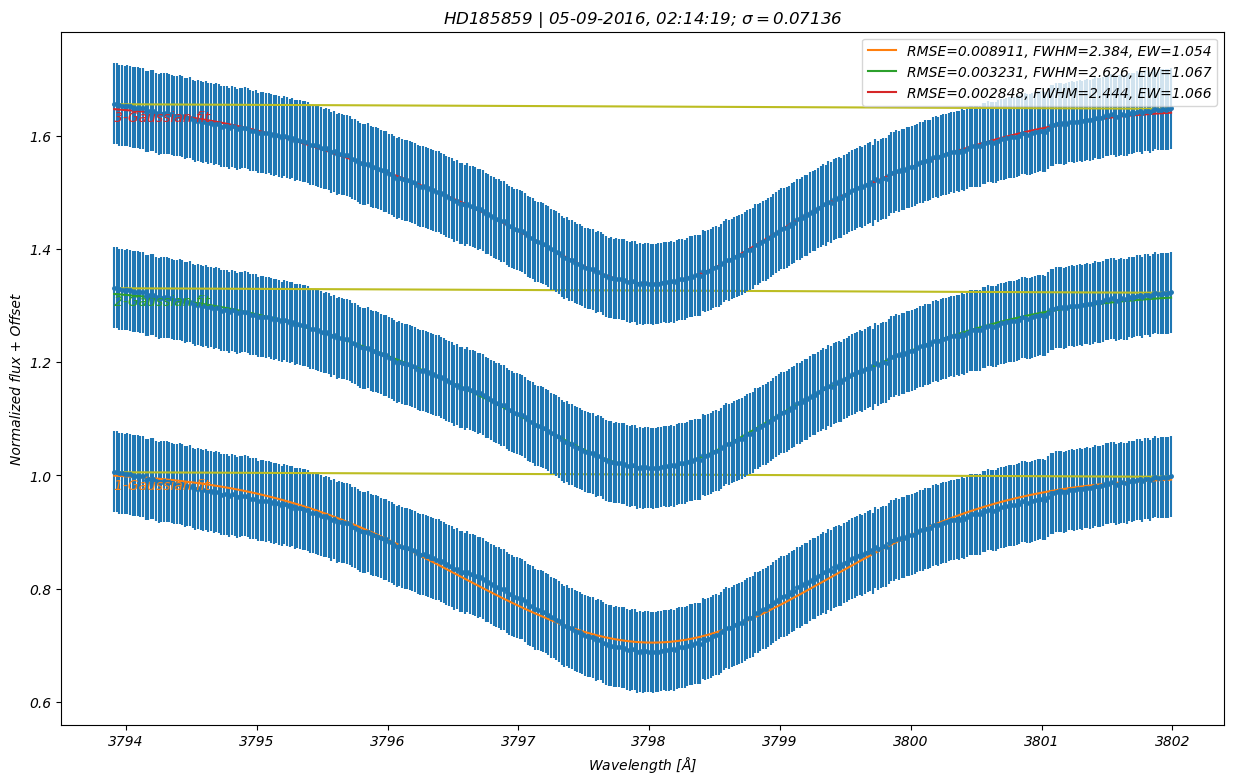

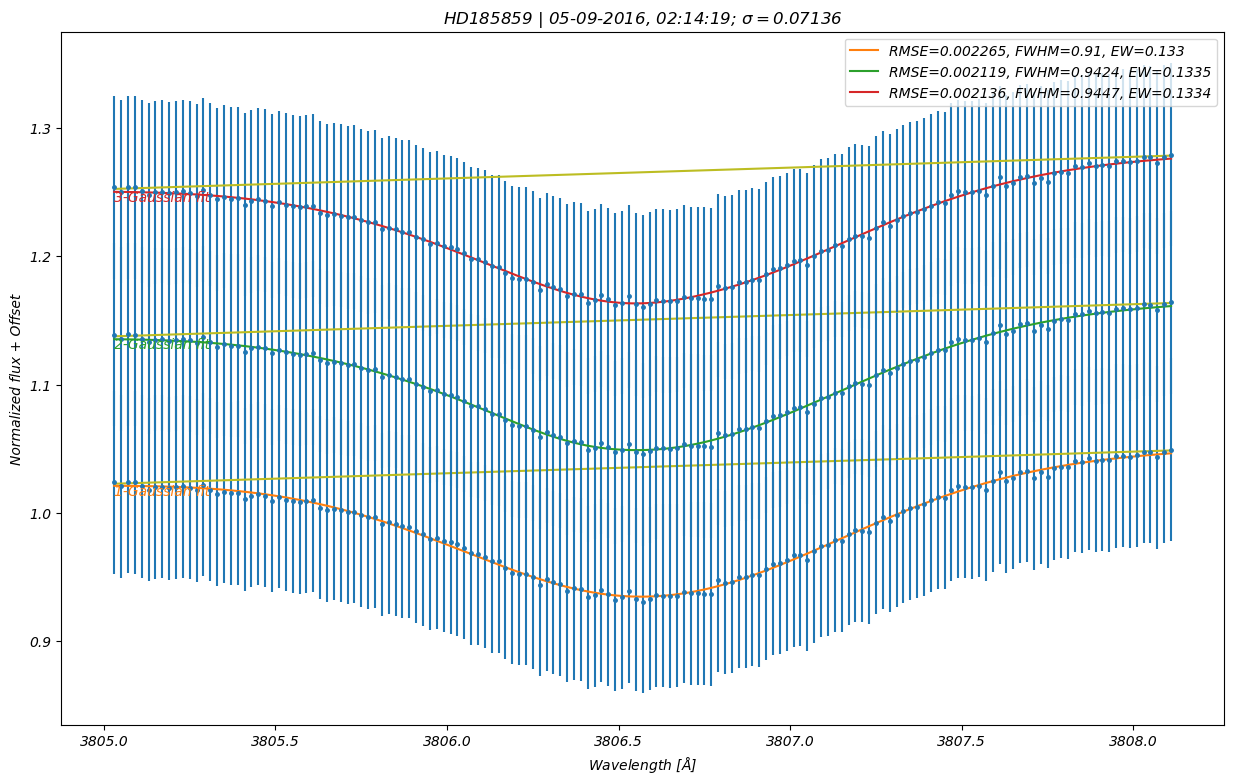

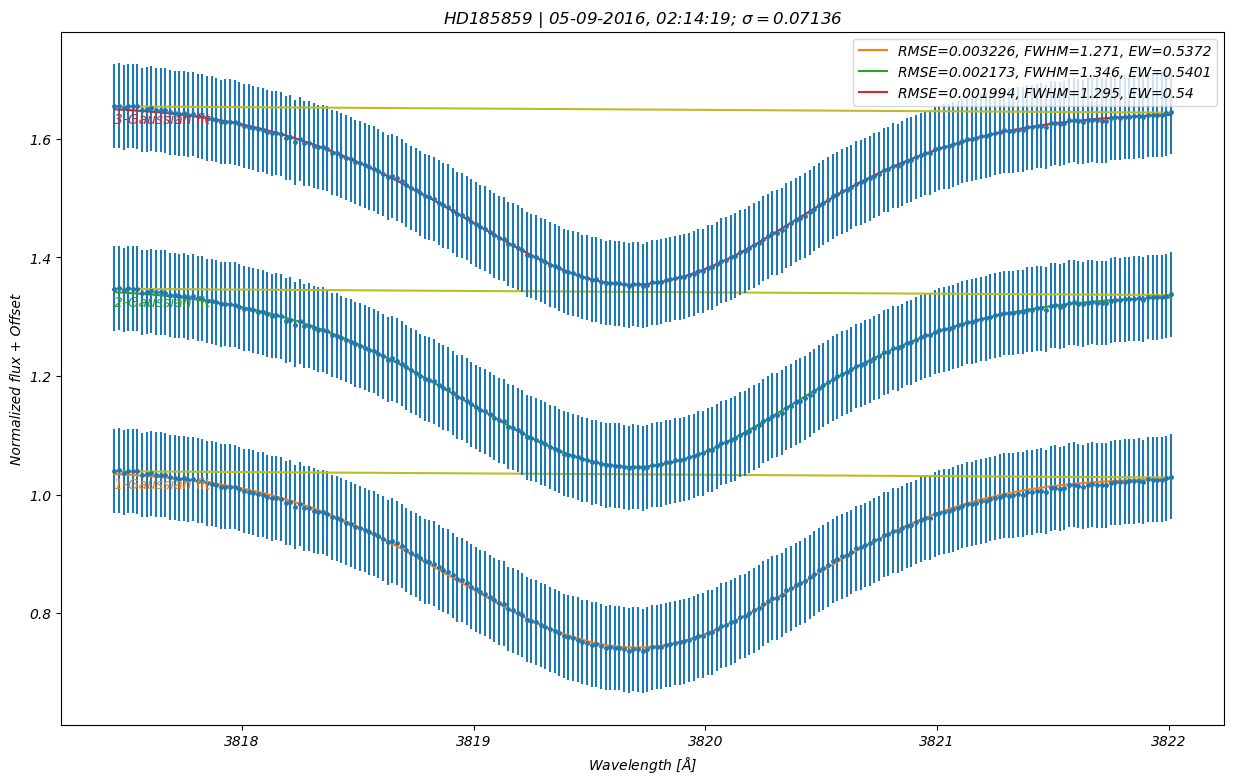

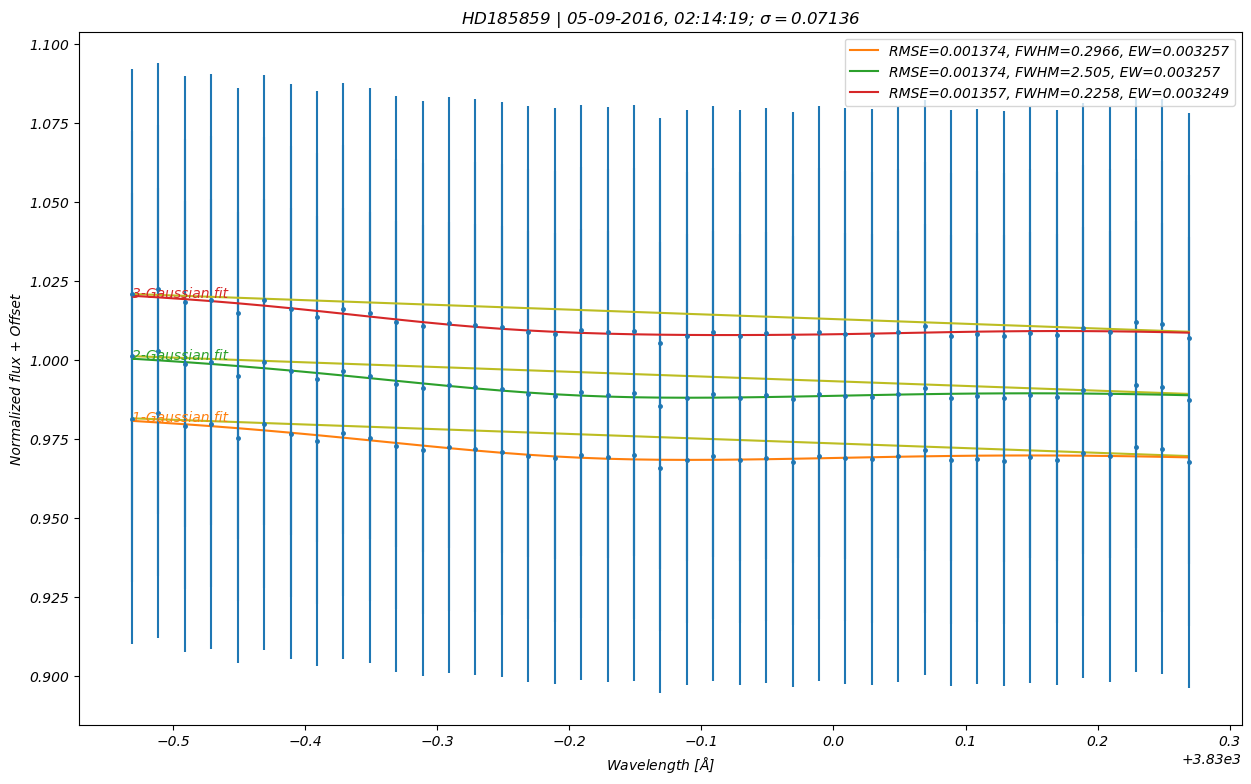

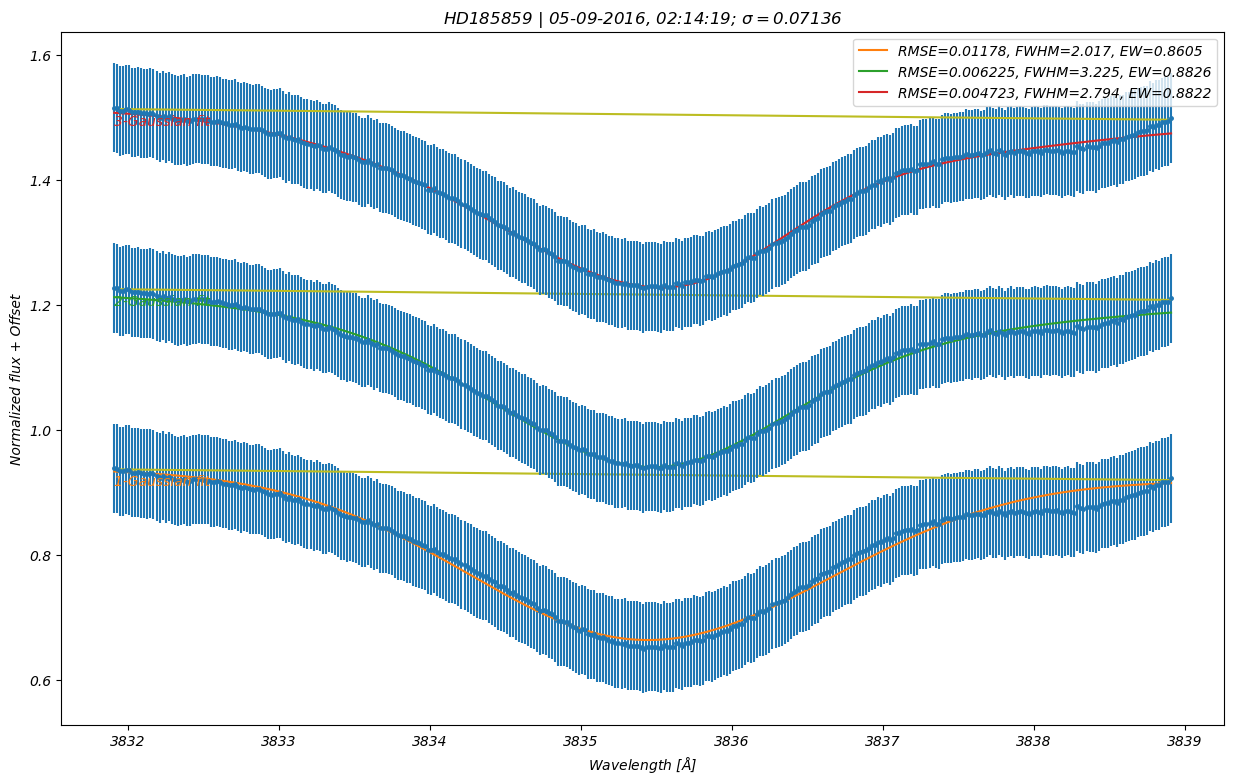

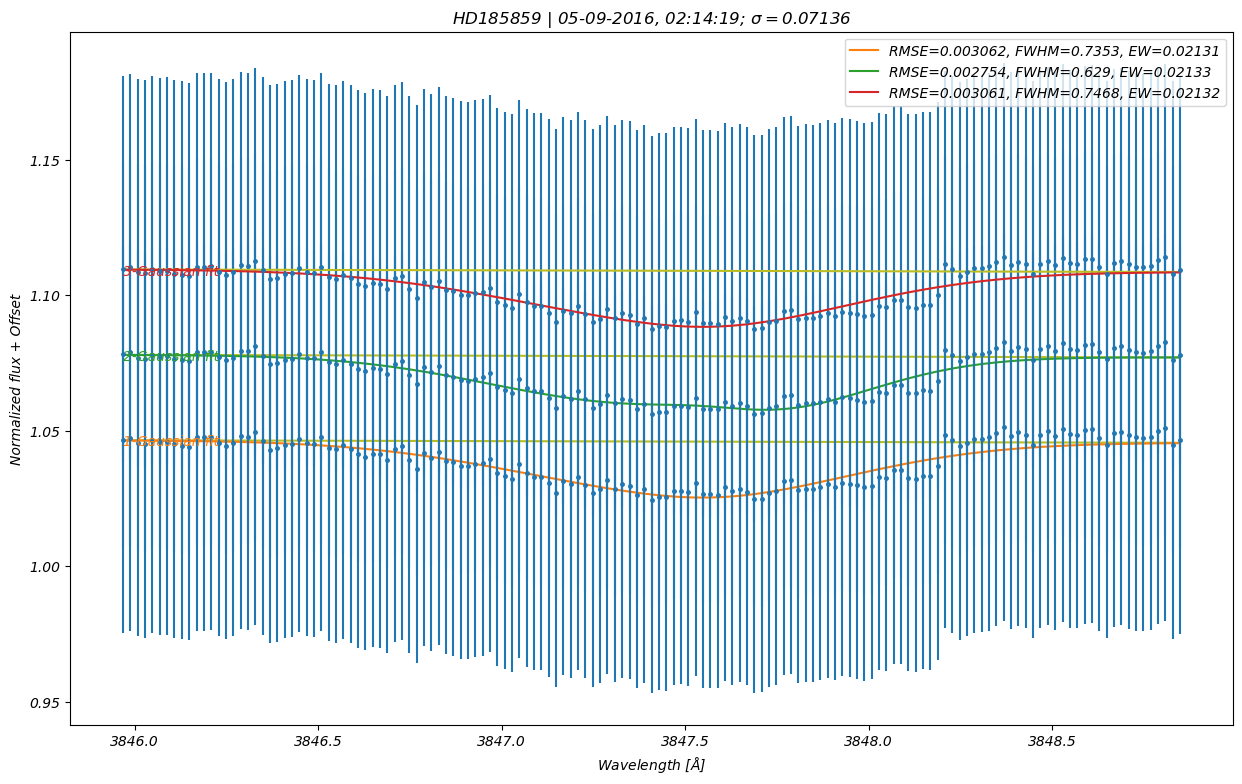

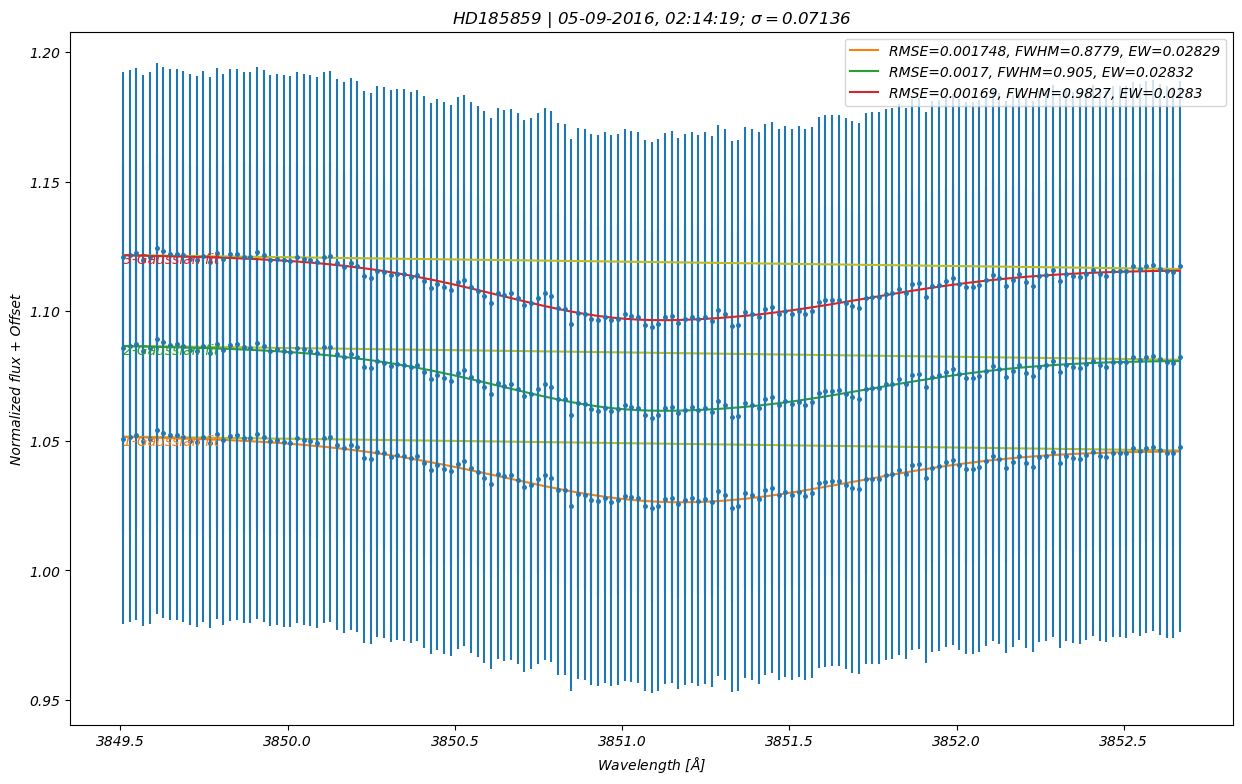

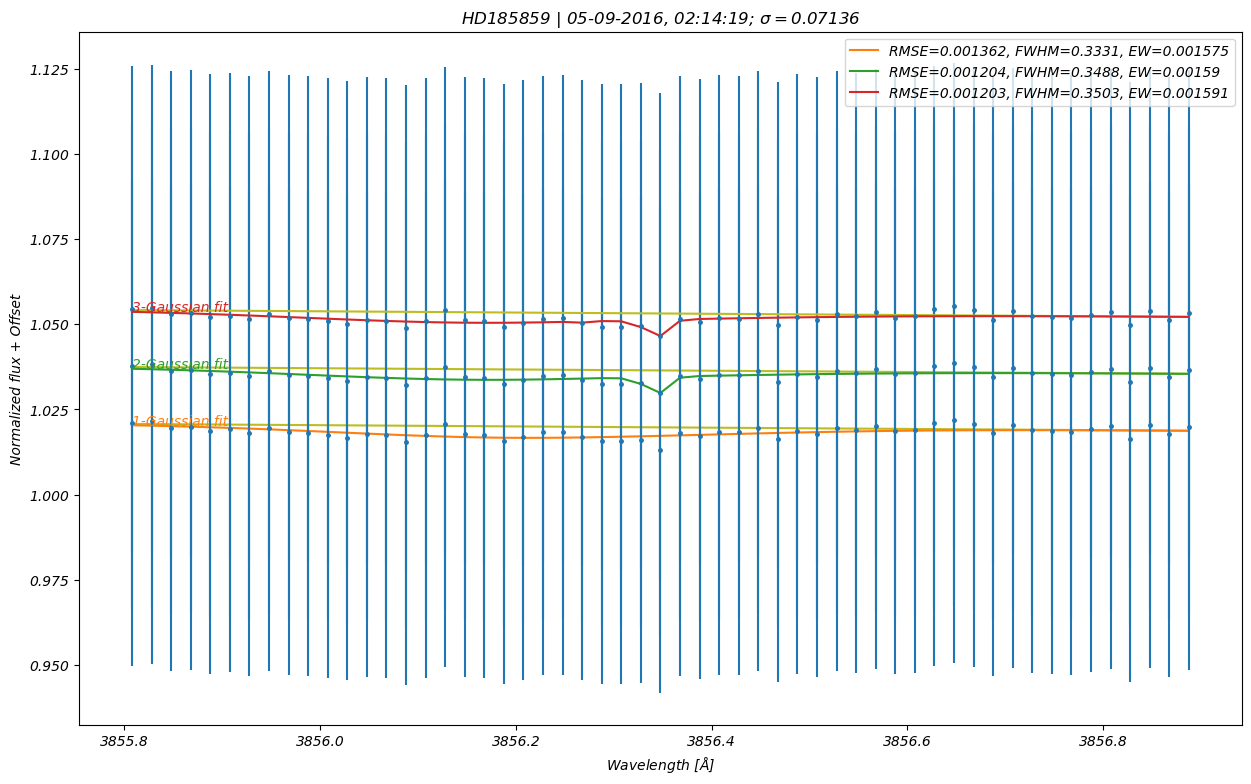

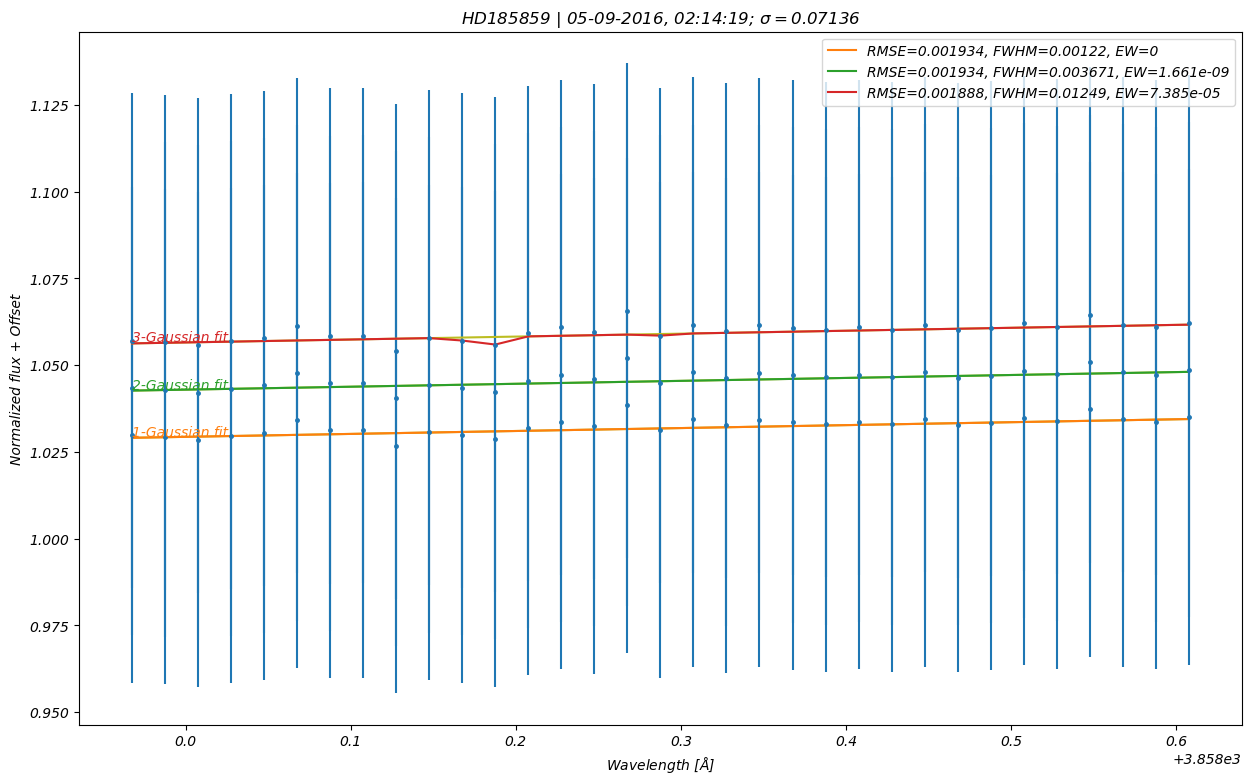

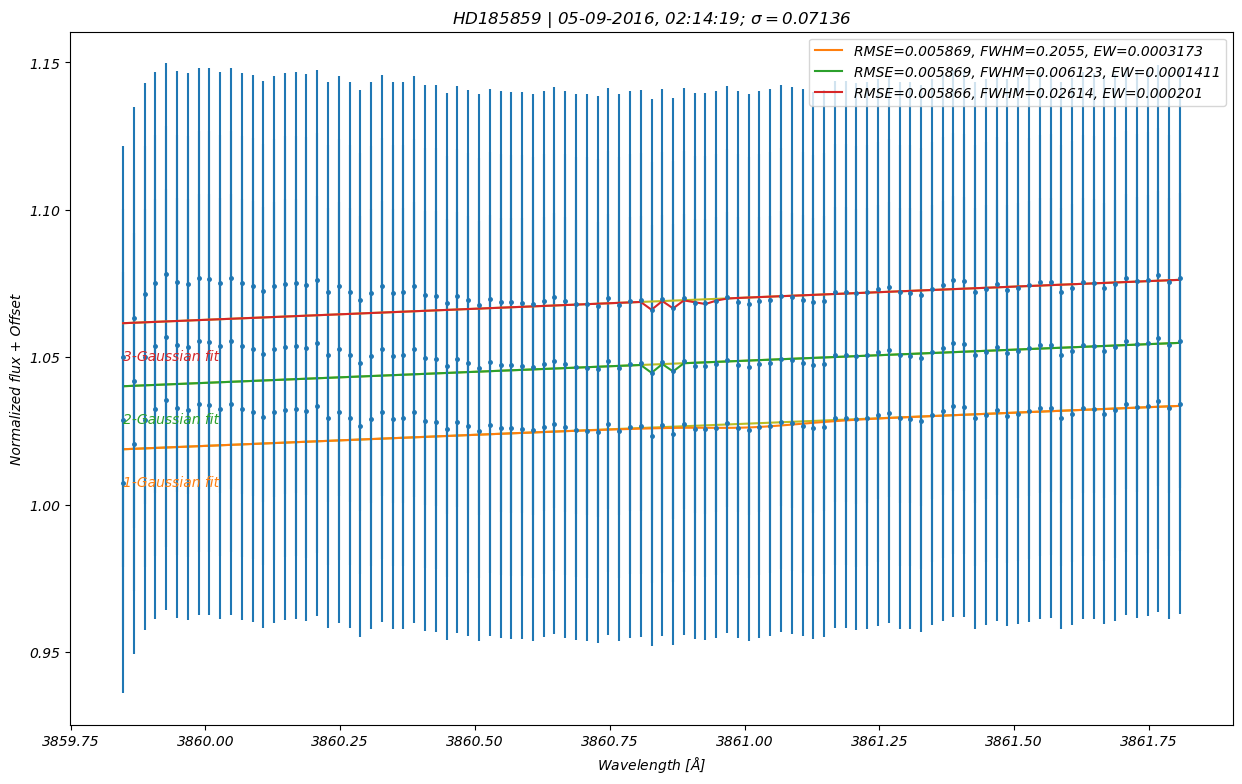

In [6]:
hd185859 = load_target('data/fits/HD185859')
sp = hd185859[1]
_ = fit_gaussian_for_subspectrum(hd185859[1], True, dib_slice=(10, 20))
# _ = fit_gaussian_for_subspectrum(hd185859[1], True, expected_dib_centers=dib_centers_all)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


sp = hd185859[1]
range_mask = (3809 < sp.wavelength) & (sp.wavelength < 3814)
wavelength = sp.wavelength[range_mask]
flux = sp.flux[range_mask]
wvl_matrix = wavelength.reshape(-1, 1)

model = LinearRegression().fit(wvl_matrix, flux)
pred = model.predict(wvl_matrix)
r2 = model.score(wvl_matrix, flux)
rmse = root_mean_squared_error(flux, pred)

plt.title(f'$R^2={r2:.4g}$, RMSE$={rmse:.4g}$')
plt.plot(wavelength, flux, '.', ms=2)
plt.plot(wavelength, pred)
plt.show()

In [ ]:
from itertools import groupby
from operator import itemgetter

gradient = np.gradient(sp.flux)
flat_mask = np.abs(gradient) < 2

indices = np.where(flat_mask)[0]
flat_regions = []
region_lengths = []
for k, g in groupby(enumerate(indices), lambda x: x[0] - x[1]):
    group = list(map(itemgetter(1), g))
    if len(group) > 50:  # Filter small regions
        flat_regions.append((group[0], group[-1]))
        region_lengths.append(len(group))

best_region = flat_regions[np.argmax(region_lengths)]
wavelength = sp.wavelength[best_region[0]:best_region[1]]
flux = sp.flux[best_region[0]:best_region[1]]
wvl_matrix = wavelength.reshape(-1, 1)

model = LinearRegression().fit(wvl_matrix, flux)
pred = model.predict(wvl_matrix)
r2 = model.score(wvl_matrix, flux)
rmse = root_mean_squared_error(flux, pred)

print(rmse)

plt.figure(figsize=(15, 3))
plt.plot(sp.wavelength, sp.flux, '.', ms=2)
plt.plot(wavelength, pred)
plt.show()

In [ ]:
_ = fit_gaussian_for_targets('HD185859', create_figure=True)

In [ ]:
_ = fit_gaussian_for_targets(['HD147889', 'HD158926', 'HD170740', 'HD185859'], dib_centers_all, export=True)


In [ ]:
fit_gaussian_for_targets(os.listdir('data/fits'), filename='gaussian_fits_all.csv')